In [1]:
import tensorflow
tensorflow.__version__

'2.3.0'

## Define random Seed and Ignore Warnnings

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install pydicom library to read DICOM files

In [4]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 9.0MB/s 


##Import basic Libraries

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
import os
from zipfile import ZipFile

##Load Data

In [ ]:
def unzipData(srcFilePath, dstFolderPath):
   os.chdir(dstFolderPath)
   with ZipFile(srcFilePath, 'r') as z:
     z.extractall()
   print("Extraction done!")

In [ ]:
##Unzip Train Images
#srcFilePath = '/content/drive/My Drive/pgp/Projects/capstone/data/stage_2_train_images.zip'
#dstFolderPath = '/content/drive/My Drive/pgp/Projects/capstone/data/dicom_train_images'
#unzipData(srcFilePath,dstFolderPath)

Extraction done!


In [ ]:
##Unzip Test Images
#srcFilePath = '/content/drive/My Drive/pgp/Projects/capstone/data/stage_2_test_images.zip'
#dstFolderPath = '/content/drive/My Drive/pgp/Projects/capstone/data/dicom_test_images'
#unzipData(srcFilePath,dstFolderPath)

Extraction done!


In [ ]:
!cd '/content/drive/My Drive/pgp/Projects/capstone/'

In [ ]:
!pwd

/content/drive/My Drive/pgp/Projects/capstone


In [ ]:
train_path = './data/dicom_train_images/'
test_path = './data/dicom_test_images'
class_path = 'data/stage_2_detailed_class_info.csv'
label_path = 'data/stage_2_train_labels.csv'

In [ ]:
##Delete files
def delete_files(data_path):
  for filename in os.listdir(data_path):
    if(filename.endswith('.dcm') == False):
      print(filename)
    else:
      os.remove(filename)

In [ ]:
!ls

data		     kaggle_download.py.gdoc  proj_1202.ipynb
download_data.ipynb  kaggle.json


## EDA and data preprocessing

In [ ]:
df_labels = pd.read_csv(label_path)
#Sample No Pneumonia case
print(df_labels.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


In [ ]:
#Sample Pneumonia case
print(df_labels.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


The DICOM files contain a combination of header metadata as well as underlying raw image arrays for pixel data

In [ ]:
patientId = df_labels['patientId'][0]
dcm_file = train_path+'%s.dcm' % patientId
dcm_data1 = pydicom.read_file(dcm_file)
#Header data
print(dcm_data1)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

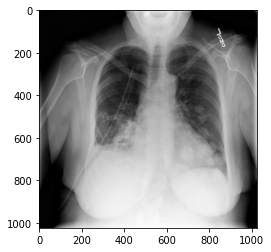

In [ ]:
#Pixel data
im = dcm_data1.pixel_array
plt.imshow(im, cmap='gist_gray')

In [ ]:
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


In [ ]:
#Take a random scanned image to check the resolution and encoding
patientId = df_labels['patientId'][134]
dcm_file = train_path+'%s.dcm' % patientId
dcm_data2 = pydicom.read_file(dcm_file)

In [ ]:
im = dcm_data2.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


We can see that both the random images have same encoding and same resolution, i.e,
1.   The image has been already rescaled to 8 bit encoding
2.   The Resolution is already rescaled to (1024, 1024)

**The Images are largely pre-processed**

Checking for data imbalance

In [ ]:
df_class = pd.read_csv(class_path)
df_class.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
df_class['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

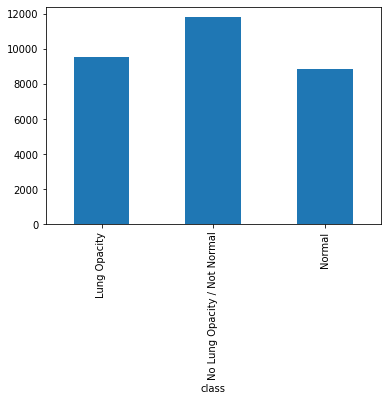

In [ ]:
df_class.groupby('class').size().plot.bar()

In [ ]:
total = df_class.shape[0]
total

30227

In [ ]:
total_labels = df_labels.shape[0]
total_labels

30227

In [ ]:
print(f'Tatal numbers of observations: {total}')

Tatal numbers of observations: 30227


In [ ]:
#df_class.groupby('patientId').size()
df_class['patientId'].unique().shape[0]

26684

In [ ]:
unique_patients = df_labels['patientId'].unique().shape[0]
unique_patients

26684

In [ ]:
print(f'Total {unique_patients} unique patients are in the data set')

Total 26684 unique patients are in the data set


The data in the class csv and label csv are same. No descripency in the data

In [ ]:
normal = df_class[df_class['class'] != 'Lung Opacity'].shape[0]
print(f'Tatal cases with no Pneumonia: {normal}')

Tatal cases with no Pneumonia: 20672


In [ ]:
pneumonia = df_class[df_class['class'] == 'Lung Opacity'].shape[0]
print(f'Tatal cases with Pneumonia: {pneumonia}')

Tatal cases with Pneumonia: 9555


In [ ]:
print(f'Percentage of total samples with no Pneumonia is {normal/total*100}')

Percentage of total samples with no Pneumonia is 68.38918847388096


In [ ]:
print(f'Percentage of total sample with Pneumonia is {pneumonia/total*100}')

Percentage of total sample with Pneumonia is 31.610811526119033


In [ ]:
plt.pie([pneumonia,normal], labels = ['Pneumonia symptoms present', 'Normal'], autopct='%1.1f%%', startangle=90)
plt.tight_layout()

NameError: ignored

Generally speaking, In most medical reports, the prevalence of the disease would be quite low. However, this Pneumonia scann images the 31.6% of total samples is positive i.e. the data is already balanced.

### Data preparation

####Lets bring the class and labels together in one data frame by concatinating

In [ ]:
bbox_label_class_df = pd.concat([df_labels, df_class.drop(columns=['patientId'], axis = 1)], axis = 1)
bbox_label_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
bbox_label_class_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


**From the above information it is clear, sample with lung opacity(1) is labeled as Pneumonia**

In [ ]:
#Distribution of the no. of bounding boxes in the data
box_df = bbox_label_class_df.groupby('patientId').size().reset_index(name='boxes')
bb_dist = box_df.groupby('boxes').size().reset_index(name='patients')
bb_dist

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


In [ ]:
bb_dist[bb_dist['boxes'] > 1]['patients'].sum()

3398

There are 3398 patients who have more than one bounding boxes in their scanned image (NaN included)

####Lets bring no of bounding boxes column for each patient

In [ ]:
box_df = bbox_label_class_df.groupby('patientId').size().reset_index(name='boxes')
bbox_label_class_no_df = pd.merge(bbox_label_class_df, box_df, on='patientId')
bbox_label_class_no_df.shape

(30227, 8)

In [ ]:
bbox_label_class_no_df.head(10)

,patientId,x,y,width,height,Target,class,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,2
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,2


In [ ]:
bbox_label_class_no_df[bbox_label_class_no_df['boxes'] >2 ].head(10)

,patientId,x,y,width,height,Target,class,boxes
122,03a9498c-549d-4e7d-800b-e74797f7f625,195.0,511.0,218.0,271.0,1,Lung Opacity,3
123,03a9498c-549d-4e7d-800b-e74797f7f625,612.0,214.0,109.0,89.0,1,Lung Opacity,3
124,03a9498c-549d-4e7d-800b-e74797f7f625,610.0,599.0,265.0,245.0,1,Lung Opacity,3
144,040a0743-f663-4746-8224-f0e3bacc7ba5,294.0,228.0,87.0,144.0,1,Lung Opacity,3
145,040a0743-f663-4746-8224-f0e3bacc7ba5,180.0,504.0,236.0,205.0,1,Lung Opacity,3
146,040a0743-f663-4746-8224-f0e3bacc7ba5,637.0,240.0,242.0,547.0,1,Lung Opacity,3
531,085a6486-c3b3-4ca2-80f1-be07d23e853b,665.0,231.0,185.0,284.0,1,Lung Opacity,3
532,085a6486-c3b3-4ca2-80f1-be07d23e853b,147.0,325.0,158.0,225.0,1,Lung Opacity,3
533,085a6486-c3b3-4ca2-80f1-be07d23e853b,332.0,422.0,155.0,249.0,1,Lung Opacity,3
697,098e14d4-3205-4c2d-a059-738f830c0aa5,126.0,592.0,142.0,188.0,1,Lung Opacity,3


####Lets bring the path of the scanned image location

In [ ]:
from glob import glob

In [ ]:
image_df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.dcm'))})

In [ ]:
image_df.head()

,path
0,./data/dicom_train_images/f79e5a75-5e15-431a-9...
1,./data/dicom_train_images/f79fa94e-8886-425c-9...
2,./data/dicom_train_images/f79fc759-fde0-4e2e-8...
3,./data/dicom_train_images/f7a169e2-a1a7-439a-a...
4,./data/dicom_train_images/f7a172fc-a34f-4155-8...


In [ ]:
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

In [ ]:
image_df.head()

,path,patientId
0,./data/dicom_train_images/f79e5a75-5e15-431a-9...,f79e5a75-5e15-431a-9ba3-de64c1724b65
1,./data/dicom_train_images/f79fa94e-8886-425c-9...,f79fa94e-8886-425c-95d4-81abfea92aee
2,./data/dicom_train_images/f79fc759-fde0-4e2e-8...,f79fc759-fde0-4e2e-8951-26ac8af5ef89
3,./data/dicom_train_images/f7a169e2-a1a7-439a-a...,f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9
4,./data/dicom_train_images/f7a172fc-a34f-4155-8...,f7a172fc-a34f-4155-806d-7b0afe2a6156


In [ ]:
image_df.shape

(26684, 2)

In [ ]:
image_bbox__label_df = pd.merge(bbox_label_class_no_df,image_df,on='patientId',how='left').sort_values('patientId')

In [ ]:
bbox_label_class_no_df.shape

(30227, 8)

In [ ]:
image_bbox__label_df.shape

(30227, 9)

In [ ]:
image_bbox__label_df.head()

,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,./data/dicom_train_images/0004cfab-14fd-4e49-8...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,./data/dicom_train_images/000924cf-0f8d-42bd-9...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,./data/dicom_train_images/000db696-cf54-4385-b...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,./data/dicom_train_images/000db696-cf54-4385-b...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,./data/dicom_train_images/000fe35a-2649-43d4-b...


####Lets bring some more features from image heade metadata

In [ ]:
attribute_list = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']

In [ ]:
def getAttributeData(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in attribute_list}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: getAttributeData(x['path']), 1)

In [ ]:
image_meta_df.shape

(26684, 5)

In [ ]:
image_meta_df['patientId'] = image_meta_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

In [ ]:
image_meta_df.head()

,PatientAge,BodyPartExamined,ViewPosition,PatientSex,path,patientId
0,59,CHEST,PA,M,./data/dicom_train_images/f79e5a75-5e15-431a-9...,f79e5a75-5e15-431a-9ba3-de64c1724b65
1,43,CHEST,PA,F,./data/dicom_train_images/f79fa94e-8886-425c-9...,f79fa94e-8886-425c-95d4-81abfea92aee
2,45,CHEST,AP,F,./data/dicom_train_images/f79fc759-fde0-4e2e-8...,f79fc759-fde0-4e2e-8951-26ac8af5ef89
3,52,CHEST,PA,M,./data/dicom_train_images/f7a169e2-a1a7-439a-a...,f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9
4,26,CHEST,AP,M,./data/dicom_train_images/f7a172fc-a34f-4155-8...,f7a172fc-a34f-4155-806d-7b0afe2a6156


In [ ]:
image_meta_df.to_csv(path_or_buf='/content/drive/MyDrive/pgp/Projects/capstone/data/image_meta_df.csv', index=False)

In [ ]:
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)

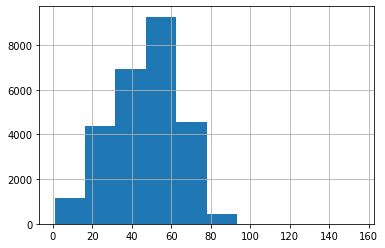

In [ ]:
image_meta_df['PatientAge'].hist()

In [ ]:
image_full_df = pd.merge(image_bbox__label_df,image_meta_df,on='patientId')

In [ ]:
image_full_df.shape

(30227, 14)

In [ ]:
image_full_df.head()

,patientId,x,y,width,height,Target,class,boxes,path_x,PatientAge,BodyPartExamined,ViewPosition,PatientSex,path_y
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,./data/dicom_train_images/0004cfab-14fd-4e49-8...,51,CHEST,PA,F,./data/dicom_train_images/0004cfab-14fd-4e49-8...
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,./data/dicom_train_images/000924cf-0f8d-42bd-9...,19,CHEST,AP,F,./data/dicom_train_images/000924cf-0f8d-42bd-9...
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,./data/dicom_train_images/000db696-cf54-4385-b...,25,CHEST,AP,F,./data/dicom_train_images/000db696-cf54-4385-b...
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,./data/dicom_train_images/000db696-cf54-4385-b...,25,CHEST,AP,F,./data/dicom_train_images/000db696-cf54-4385-b...
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,./data/dicom_train_images/000fe35a-2649-43d4-b...,40,CHEST,AP,M,./data/dicom_train_images/000fe35a-2649-43d4-b...


In [ ]:
image_meta_df.to_csv(path_or_buf='/content/drive/MyDrive/pgp/Projects/capstone/data/image_full_df.csv', index=False)